<a href="https://colab.research.google.com/github/pauchai/SubPlayer/blob/master/Paul%20Himyak/main_08_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import re
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import concatenate, Embedding, Conv1D, Input, Dense, Dropout, BatchNormalization, Flatten , SpatialDropout1D, Reshape, RepeatVector, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
from tensorflow.keras import utils
import tensorflow as tf
!pip install -q tensorflow-addons
import tensorflow_addons as tfad

import sklearn.metrics as skl_metrics




import gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg"
#dataset_url = "https://docs.google.com/spreadsheets/d/1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg/edit?usp=share_link&ouid=113369956649761615778&rtpof=true&sd=true"
dataset_filename = "profpatolog_modified.xlsx"
#!wget -qc dataset_url -O dataset_filename
gdown.download(dataset_url, output=dataset_filename, quiet=True )


'profpatolog_modified.xlsx'

In [ ]:
df = pd.read_excel("profpatolog_modified.xlsx")


In [ ]:
del df['Unnamed: 0']

In [ ]:
FIELD_CLIENT_AGE = "КлиентВозраст"
FIELD_CLIENT_BIRTH_DAY = "КлиентДатаРождения"
FIELD_CLIENT_GENDER = "КлиентПол"
FIELD_CLIENT_GENDER_M = 0
FIELD_CLIENT_GENDER_F = 1
FIELD_CONCLUSION = "ЗаключениеМК"
FIELD_CONCLUSION_FIT = 1
FIELD_CONCLUSION_PART_FIT = 2
FIELD_CONCLUSION_NOT_FIT = 0

FIELD_DISPANSARY_GROUP = "ДиспансернаяГруппа"
FIELD_DISPANSARY_GROUP_I = 0
FIELD_DISPANSARY_GROUP_II = 1
FIELD_DISPANSARY_GROUP_III = 2
FIELD_DISPANSARY_GROUP_OTHER = 3

FIELD_HARMFUL_FACTORS = "ВредныеФакторы"


FIELD_NEW_AGE_CATEGORY = "ВозрастКатегория"
FIELD_NEW_MKBS = "mkbs"

FIELD_CLIENT_PROFESSION = "Профессия"
FIELD_NEW_CLIENT_PROFESSION = "Profession"
FIELD_NEW_CLIENT_ADDITIONS = "Дополнения сводные"
FIELD_NEW_CLIENT_DIAG = "Diagnoz"

In [ ]:
import re
#функция из названя столбца выделяет первое значение
def extract_specialist_from_column_name(string):
    # Выделить первую часть до символа `_`
    first_part = string.split("_")[0]

    # Разбить первую часть на слова по стилю CamelCase и исключить цифры
    words = re.findall('[A-ZА-ЯЁ][a-zа-яё]*', first_part)

    # Объединить слова в строку с пробелами
    result = ' '.join(words)

    return result
extract_specialist_from_column_name("ПсихиатрияНаркология1_ДиагнозПредставление1")

'Психиатрия Наркология'

In [ ]:
#функция объединения ячеек в одну удаляя ненужный символ и объединяя вместе с названиями колонок
def join_not_nan_columns(df, columns_filter, value_for_unset = None):
  if value_for_unset is not None:
    df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)
  return df[columns_filter.columns].apply(lambda row: ",".join(f"{extract_specialist_from_column_name(column_name)} {value}" for column_name, value in zip(columns_filter.columns, row) if pd.notna(value)), axis=1)
  



In [ ]:
diag_filter = df.filter(regex="(?i)Диагноз\s?Представление")
df[FIELD_NEW_CLIENT_DIAG] =  join_not_nan_columns(df, diag_filter, value_for_unset="Общий медицинский осмотр")
#Удаляю ненужные колонки
df = df.drop(columns=diag_filter)

<ipython-input-8-15e3a35bde05>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)


In [ ]:
additions_filter = df.filter(regex="(?i)Дополнение_Значение$")
df[FIELD_NEW_CLIENT_ADDITIONS] = join_not_nan_columns(df, additions_filter)
df = df.drop(columns=additions_filter)

In [ ]:
mkbs_filter = df.filter(regex="(?i)МКБ10")
df[FIELD_NEW_MKBS] = join_not_nan_columns(df, mkbs_filter, value_for_unset="Z00.0")
df = df.drop(columns=mkbs_filter)

<ipython-input-8-15e3a35bde05>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)


In [ ]:
df 

,КлиентДатаРождения,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Профессия,Diagnoz,Дополнения сводные,mkbs
0,1976-10-24,Женский,Годен,I,11.4,Ведущий специалист по организации обуения,,"Эндоскопия Дискинезия желчевыводящих путей ,Те...",
1,1987-11-18,Мужской,Годен,IIIа,4.2.5,Ведущий специалист,Терапия Гипертензивная [гипертоническая] болез...,Терапия В анамнезе ГБ,Терапия I11.9
2,1985-09-08,Мужской,ГоденСКоррекциейЗрения,II,4.2.5,Главный менеджер,Офтальмология Миопия,"Терапия карбомезипин,мексидол,Офтальмология но...",Офтальмология H52.1
3,1988-04-25,Мужской,Годен,I,11.1,Главный специалист,,Эндоскопия Патологии со стороны слизистой пище...,
4,1984-04-17,Мужской,ГоденСКоррекциейЗрения,II,11.1,Старший специалист,Офтальмология Астигматизм,"Эндоскопия Без патологии.,Офтальмология носит ...",Офтальмология H52.2
...,...,...,...,...,...,...,...,...,...
1973,1972-11-12,Мужской,NaN,NaN,6.1,Директор по строительству,,,
1974,1986-07-09,Мужской,NaN,NaN,6.1,Начальник производственно-технического отдела,,,
1975,1994-05-12,Мужской,NaN,NaN,"5.1,23",Помощник кладовщика,Стоматология Кариес дентина,Психиатрия Наркология Тесты на обобщение и иск...,Стоматология K02.1
1976,1972-04-17,Женский,NaN,NaN,23,Повар,Терапия Гипертензивная [гипертоническая] болез...,"Терапия Гипертоническая болезнь, принимает Амл...",Терапия I11.9


In [ ]:
from datetime import datetime
class MyUtils:
  conclusion_map = {FIELD_CONCLUSION_FIT:'Годен', FIELD_CONCLUSION_PART_FIT:"Частично годен", FIELD_CONCLUSION_NOT_FIT: 'Негоден'}
  @classmethod
  def conclusion_labels(cls):
    return  [cls.conclusion_map[k] for k in sorted(cls.conclusion_map)]

  @classmethod
  def resolve_conclusion_map(cls,x):
    return cls.conclusion_map[x]
  @staticmethod  
  # Определяем функцию для расчета возраста на основе даты
  def resolve_birthdate_to_age(date):
    current_year = pd.Timestamp.now().year
    age = current_year - date.year
    return age
  def resolve_genger(x):
    if x == 'Мужской':
        return FIELD_CLIENT_GENDER_M
    elif x == 'Женский':
        return FIELD_CLIENT_GENDER_F
    else:
        return None

  def resolve_conclusion_binary(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_conclusion(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      elif "Негоден" in arg:
        return FIELD_CONCLUSION_NOT_FIT
      elif "Годен" in arg:
        return FIELD_CONCLUSION_PART_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_dispansary_group(arg):
    try:
      if arg == "I":
        return FIELD_DISPANSARY_GROUP_I
      elif arg == "II":
        return FIELD_DISPANSARY_GROUP_II
      elif "III" in arg :
        return FIELD_DISPANSARY_GROUP_III
      else:
        return FIELD_DISPANSARY_GROUP_OTHER
    except (TypeError):
        return None
  def resolve_age_to_category(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
# Преобразование заключения в цифру
df[FIELD_CONCLUSION] = df[FIELD_CONCLUSION].apply(lambda x: MyUtils.resolve_conclusion(x))

In [ ]:
def ___unused___balance_dataset():
  # Разделим данные по значениям поля FIELD_CONCLUSION
  fit = df[df[FIELD_CONCLUSION] == FIELD_CONCLUSION_FIT]
  not_fit = df[df[FIELD_CONCLUSION] == FIELD_CONCLUSION_NOT_FIT]
  part_fit = df[df[FIELD_CONCLUSION] == FIELD_CONCLUSION_PART_FIT]

  # Увеличим меньшие классы до размера большего класса
  n_samples = len(fit)
  not_fit_upsampled = resample(not_fit, replace=True, n_samples=n_samples, random_state=42)
  part_fit_upsampled = resample(part_fit, replace=True, n_samples=n_samples, random_state=42)

  # Объединим данные и перемешаем их
  df_balanced = pd.concat([fit, not_fit_upsampled, part_fit_upsampled])
  df_balanced = df_balanced.sample(frac=1, random_state=42)


In [ ]:
# Преобразование колонки возраста в цифровой вид
df[FIELD_CLIENT_AGE] = df[FIELD_CLIENT_BIRTH_DAY].apply(MyUtils.resolve_birthdate_to_age)

# разделение возраста на категории
df[FIELD_NEW_AGE_CATEGORY] = df[FIELD_CLIENT_AGE].apply(MyUtils.resolve_age_to_category)

# Пол в цифру
df[FIELD_CLIENT_GENDER] = df[FIELD_CLIENT_GENDER].apply(lambda x: MyUtils.resolve_genger(x) if pd.notnull(x) else x)

# Удалим неиспользованные колонки
del df[FIELD_CLIENT_BIRTH_DAY]
del  df[FIELD_CLIENT_AGE]

In [ ]:
#Преобразование диспансерных групп в цифру
df[FIELD_DISPANSARY_GROUP] = df[FIELD_DISPANSARY_GROUP].apply(MyUtils.resolve_dispansary_group)

In [ ]:
# разделяем факторы по одному значению
df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")

In [ ]:
df.dropna(inplace = True)

Подготавливаю все однозначные цифровые данные в OHE

In [ ]:
# Объединяю категориальные значения в OHE
df_ohe  = pd.get_dummies(df[[FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY]],  columns = [FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY] )
xTrain0 = df_ohe.values
xTrain0.shape


(1562, 16)

In [ ]:
yTrain =  pd.get_dummies(df[FIELD_CONCLUSION]).values

In [ ]:
Y_CLASSES = yTrain.shape[1]
Y_CLASSES

3

In [ ]:
df

,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Профессия,Diagnoz,Дополнения сводные,mkbs,ВозрастКатегория
0,1,1.0,0.0,[11.4],Ведущий специалист по организации обуения,,"Эндоскопия Дискинезия желчевыводящих путей ,Те...",,6
1,0,1.0,2.0,[4.2.5],Ведущий специалист,Терапия Гипертензивная [гипертоническая] болез...,Терапия В анамнезе ГБ,Терапия I11.9,4
2,0,2.0,1.0,[4.2.5],Главный менеджер,Офтальмология Миопия,"Терапия карбомезипин,мексидол,Офтальмология но...",Офтальмология H52.1,5
3,0,1.0,0.0,[11.1],Главный специалист,,Эндоскопия Патологии со стороны слизистой пище...,,4
4,0,2.0,1.0,[11.1],Старший специалист,Офтальмология Астигматизм,"Эндоскопия Без патологии.,Офтальмология носит ...",Офтальмология H52.2,5
...,...,...,...,...,...,...,...,...,...
1956,0,1.0,1.0,"[4.4, 4.5, 6.1]",Инженер,Офтальмология Миопия,"Офтальмология 1,0,Офтальмология -0,75 -0,50/-0,50",Офтальмология H52.1,4
1957,0,1.0,0.0,"[4.4, 4.5, 6.1]",Инженер,,,,3
1958,0,1.0,0.0,[4.4],Начальник лаборатории,,,,4
1968,0,1.0,0.0,[3.1.8.2],"Инженер по бурению 1 категории, непосредственн...",,,,4


Токенизируем наши поля

Это моя обертка над токенизатором, для удобства использования для повторяющейся задачи

In [ ]:
np_len = np.vectorize(len)


class MySequences:
  value = None
  max_len = None
  def get_padded(self):
    return pad_sequences(self.value, maxlen=self.max_len, padding='post')


class MyTokenizer:
  tokenizer:Tokenizer
  _indexed = None
  def __init__(self, *tokenizer_args, **tokenizer_kwargs):
    self.tokenizer = Tokenizer(*tokenizer_args, **tokenizer_kwargs)
    
  @property
  def vocab_size(self):
    return len(self.tokenizer.word_index) + 1
 
  def fit_on_texts(self, series):
    self.tokenizer.fit_on_texts(series)
 
  def texts_to_sequences(self, series):
    
    self._indexed = MySequences()


    self._indexed.value = self.tokenizer.texts_to_sequences(series)
    self._indexed.max_len = np_len(self._indexed.value).max()
    return self._indexed
  
  def process_data(self, series):
    self.fit_on_texts(series)
    self.texts_to_sequences(series)
  
  @property
  def indexed(self)->MySequences:
    return self._indexed

  def __call__(self):
    return self.tokenizer

Токенизируем колонки

In [ ]:
df[FIELD_NEW_MKBS]

0                          
1             Терапия I11.9
2       Офтальмология H52.1
3                          
4       Офтальмология H52.2
               ...         
1956    Офтальмология H52.1
1957                       
1958                       
1968                       
1969                       
Name: mkbs, Length: 1562, dtype: object

In [ ]:
#Токенизируем МКБ и подготавиваем для трейна
tokenizer_mkb = MyTokenizer()
tokenizer_mkb.process_data(df[FIELD_NEW_MKBS])
xTrainMkb = tokenizer_mkb.indexed.get_padded()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [ ]:
df[FIELD_HARMFUL_FACTORS]

0                [11.4]
1               [4.2.5]
2               [4.2.5]
3                [11.1]
4                [11.1]
             ...       
1956    [4.4, 4.5, 6.1]
1957    [4.4, 4.5, 6.1]
1958              [4.4]
1968          [3.1.8.2]
1969       [4.2.5, 6.1]
Name: ВредныеФакторы, Length: 1562, dtype: object

In [ ]:
#Токенизируем Вредные Факторы  и подготавиваем для трейна
tokenizer_harmfull = MyTokenizer()
tokenizer_harmfull.process_data(df[FIELD_HARMFUL_FACTORS])
xTrainHarmFull = tokenizer_harmfull.indexed.get_padded()


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [ ]:
df[FIELD_CLIENT_PROFESSION]

0               Ведущий специалист по организации обуения
1                                      Ведущий специалист
2                                        Главный менеджер
3                                      Главный специалист
4                                      Старший специалист
                              ...                        
1956                                              Инженер
1957                                              Инженер
1958                                Начальник лаборатории
1968    Инженер по бурению 1 категории, непосредственн...
1969                             Приемщик вагонов в депо 
Name: Профессия, Length: 1562, dtype: object

In [ ]:
#Токенизируем Профессии и подготавиваем для трейна
tokenizer_prof = MyTokenizer(num_words=1000, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_prof.process_data(df[FIELD_CLIENT_PROFESSION]) 
xTrainProf = tokenizer_prof.indexed.get_padded()



/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [ ]:
df[FIELD_NEW_CLIENT_ADDITIONS]

0       Эндоскопия Дискинезия желчевыводящих путей ,Те...
1                                   Терапия В анамнезе ГБ
2       Терапия карбомезипин,мексидол,Офтальмология но...
3       Эндоскопия Патологии со стороны слизистой пище...
4       Эндоскопия Без патологии.,Офтальмология носит ...
                              ...                        
1956    Офтальмология 1,0,Офтальмология -0,75 -0,50/-0,50
1957                                                     
1958                                                     
1968                                                     
1969    Офтальмология 2019г Лазик (-3.0),Психиатрия На...
Name: Дополнения сводные, Length: 1562, dtype: object

In [ ]:
#Токенизируем Дополнительные комментарии специалистов и подготавиваем для трейна
tokenizer_additions = MyTokenizer(num_words=1000, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_additions.process_data(df[FIELD_NEW_CLIENT_ADDITIONS]) 
xTrainAdditions = tokenizer_additions.indexed.get_padded()



In [ ]:
df[FIELD_NEW_CLIENT_DIAG]

0                                                        
1       Терапия Гипертензивная [гипертоническая] болез...
2                                    Офтальмология Миопия
3                                                        
4                               Офтальмология Астигматизм
                              ...                        
1956                                 Офтальмология Миопия
1957                                                     
1958                                                     
1968                                                     
1969                                                     
Name: Diagnoz, Length: 1562, dtype: object

In [ ]:
#Токенизируем Сводные диагнозы и подготавиваем для трейна
tokenizer_diagnose = MyTokenizer(num_words=1000, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_diagnose.process_data(df[FIELD_NEW_CLIENT_DIAG]) 
xTrainDiag = tokenizer_diagnose.indexed.get_padded()


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


In [ ]:
x_train, x_test, x_train_mkb, x_test_mkb, x_train_harmfull, x_test_harmfull, x_train_prof, x_test_prof, x_train_additions, x_test_additions, x_train_diag, x_test_diag,  y_train, y_test = train_test_split(xTrain0,
                                                                                                              xTrainMkb,
                                                                                                              xTrainHarmFull,
                                                                                                              xTrainProf,
                                                                                                              xTrainAdditions, 
                                                                                                              xTrainDiag,                                                                                                            
                                                                                                              yTrain, 
                                                                                                              test_size=0.2,
                                                                                                              shuffle = False)

In [ ]:
from os import name
# На этот вход подаются все OHE
input0 = Input((x_train.shape[1], ), name="OHE")
# Сюда подаются mkb в виде последовательности токенов , поскольку они уже объединины в одой колонке
input_mkb = Input((x_train_mkb.shape[1],), name="MKB")
# Сюда подаются вредные факторы тоже аналогично мкб , как будто это предложение из токенов 
input_harmfull = Input((x_train_harmfull.shape[1],), name="harm")
# Сюда подаются профессии , тоже как предложение токенов
input_prof = Input((x_train_prof.shape[1],), name="prof")
# Дополнения от специалистов
input_additions = Input((x_train_additions.shape[1],), name="additions")
# Диагнозы от специалистов (текст)
input_diag = Input((x_train_diag.shape[1],), name="diag")

In [ ]:
print(
    input_harmfull.shape,
    input_prof.shape,
    input_additions.shape,
    input_diag.shape
)


(None, 13) (None, 12) (None, 117) (None, 108)


In [ ]:
def create_model1(input0, input_mkb, input_harmfull, input_prof):
  x0 = BatchNormalization()(input0)
  x0 = Dense(1024, activation='relu') (x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(768, activation='sigmoid')(x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(512, activation='sigmoid')(x0)

  x1 = Embedding(tokenizer_mkb.vocab_size, 128,  input_length = tokenizer_mkb.indexed.max_len)(input_mkb)
  x1 = SpatialDropout1D(0.2)(x1)
  x1 = Dense(100, activation = 'sigmoid')(x1)
  #x1 = Flatten()(x1)

  x2 = Embedding(tokenizer_harmfull.vocab_size, 128, input_length = tokenizer_harmfull.indexed.max_len)(input_harmfull)
  x2 = SpatialDropout1D(0.2)(x2)
  x2 = Dense(100, activation = 'sigmoid')(x2)
  #x2 = Flatten()(x2)

 # x3 = Embedding(prof_vocab_size, 256, input_length = prof_max_len)(input_prof)
 # x3 = SpatialDropout1D(0.2)(x3)
  x3 = Dense(100, activation = 'sigmoid')(input_prof)
  x3 = Reshape((1, 100))(x3)

  #x3 = Flatten()(x3)

  x_ = concatenate([x1, x2, x3], axis = -2)
  x_ = Flatten()(x_)
  x = concatenate([x0, x_])


  x = Dense(800, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(Y_CLASSES, activation='softmax')(x)

  return Model((input0, input_mkb, input_harmfull, input_prof), x )


Модель 1

In [ ]:
#model1 = create_model1(input0, input_mkb, input_harmfull, input_prof)
#utils.plot_model(model1, dpi=60, show_shapes = True)


In [ ]:
def f1_score_keras(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Округление предсказанных значений до 0 или 1
    return skl_metrics.f1_score(y_true, y_pred)

f1score = tfad.metrics.F1Score(num_classes=Y_CLASSES)


In [ ]:
#model1.compile(optimizer = Adam(learning_rate = 1e-5), loss = keras_losses.categorical_crossentropy, metrics=['mae', 'accuracy'])

In [ ]:

# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [ ]:
#history = model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
#                    y_train,
#                    batch_size=32,
#                    epochs = 100,
#                    validation_split = 0.2,
#                    verbose = 1)

In [ ]:
#model1.save("drive/MyDrive/prof_patolog/model1.h5")

In [ ]:
#дообучение
#model1.compile(optimizer = Adam(learning_rate = 5e-6), loss = keras_losses.categorical_crossentropy, metrics=['mae', 'accuracy'])
#history = model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof], #model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
##                    y_train,
#                    batch_size=32,
#                    epochs = 50,
#                    validation_split = 0.2,
#                    verbose = 1)

In [ ]:
#compare_sharp_loss(history, 10, 4)

Модель 2

In [ ]:
x0 = BatchNormalization()(input0)
x0 = Dense(1024, activation='relu') (x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(768, activation='sigmoid')(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(512, activation='sigmoid')(x0)

x1 = Embedding(tokenizer_mkb.vocab_size, 128, input_length = tokenizer_mkb.indexed.max_len)(input_mkb)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Conv1D(128,3, activation = 'relu', padding='same')(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dense(256, activation = 'sigmoid')(x1)
#x1 = Flatten()(x1)

x2 = Embedding(tokenizer_harmfull.vocab_size, 128, input_length = tokenizer_harmfull.indexed.max_len)(input_harmfull)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Conv1D(128,3, activation = 'relu', padding='same')(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dense(256, activation = 'relu')(x2)
#x2 = Flatten()(x2)

x3 = Embedding(tokenizer_prof.vocab_size, 256, input_length = tokenizer_prof.indexed.max_len)(input_prof)
x3 = SpatialDropout1D(0.2)(x3)
x3 = Conv1D(128,2, activation = 'relu', padding='same')(x3)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dense(256, activation = 'relu')(x3)
#x3 = Flatten()(x3)

x4 = Embedding(tokenizer_additions.vocab_size, 256, input_length = tokenizer_additions.indexed.max_len)(input_additions)
x4 = SpatialDropout1D(0.2)(x4)
x4 = Conv1D(128,2, activation = 'relu', padding='same')(x4)
x4 = GlobalMaxPooling1D()(x4)
x4 = Dense(256, activation = 'relu')(x4)
#x3 = Flatten()(x3)

x = concatenate([x0,x1, x2, x3, x4])
x = Dense(800, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(Y_CLASSES, activation='softmax')(x)

model2 =  Model((input0, input_mkb, input_harmfull, input_prof, input_additions), x )
model2.compile(optimizer = Adam(learning_rate = 1e-4), loss = keras_losses.mse, metrics=[keras_metrics.mae, f1score])


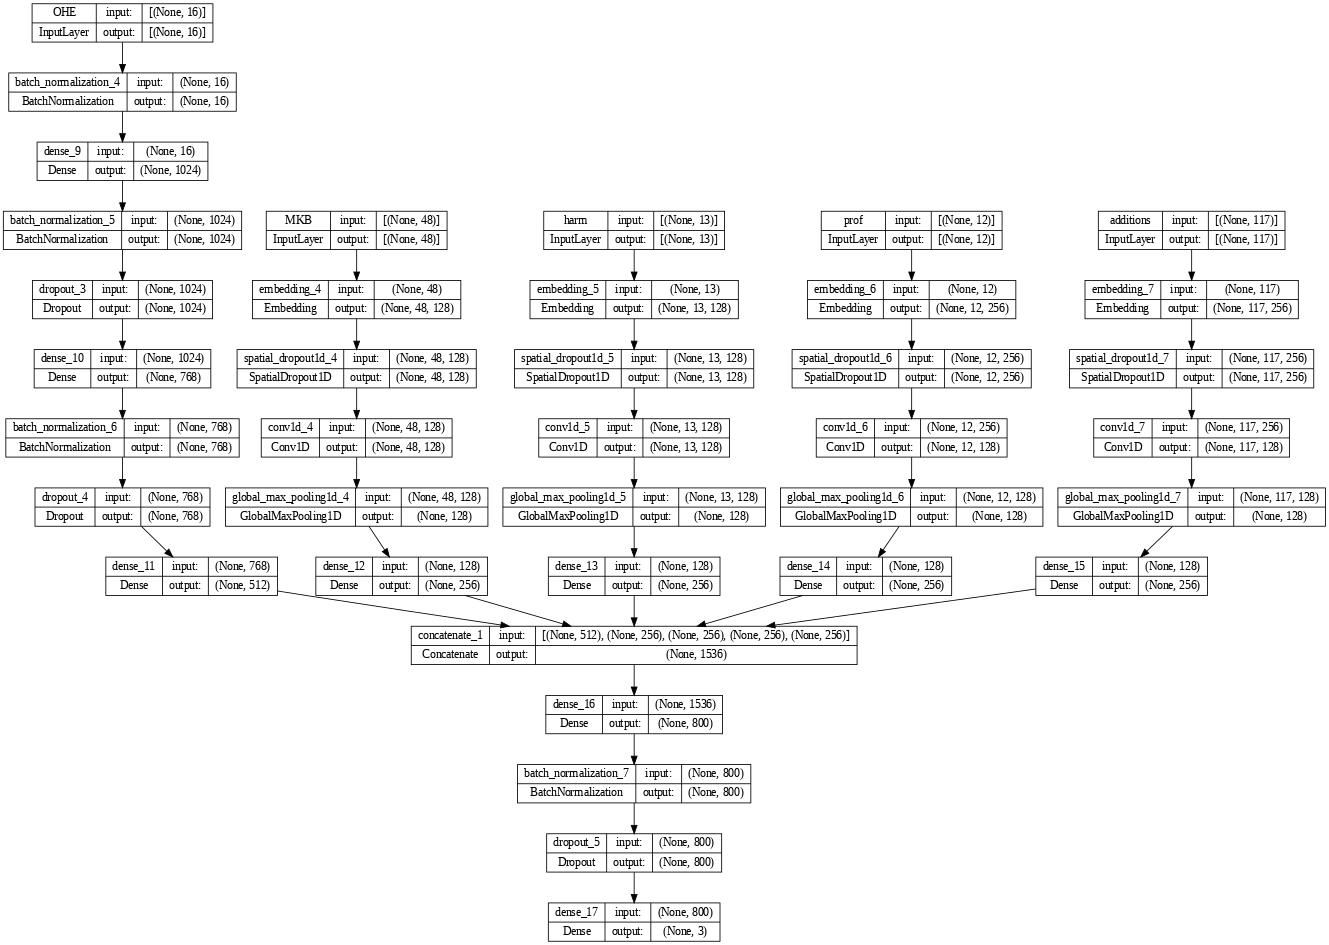

In [ ]:
utils.plot_model(model2, dpi=60, show_shapes = True)


In [ ]:
print(x_train.shape,x_train_mkb.shape, x_train_harmfull.shape, x_train_prof.shape, x_train_additions.shape)

(1249, 16) (1249, 48) (1249, 13) (1249, 12) (1249, 117)


In [ ]:
history = model2.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof, x_train_additions],
                    y_train,
                    batch_size=32,
                    epochs = 70,
                    validation_split = 0.20,
                    verbose = 1)

Epoch 1/70
32/32 [==============================] - 39s 633ms/step - loss: 0.2403 - mean_absolute_error: 0.3551 - f1_score: 0.3069 - val_loss: 0.1514 - val_mean_absolute_error: 0.3631 - val_f1_score: 0.3158
Epoch 2/70
32/32 [==============================] - 7s 190ms/step - loss: 0.1654 - mean_absolute_error: 0.2426 - f1_score: 0.3896 - val_loss: 0.1178 - val_mean_absolute_error: 0.3150 - val_f1_score: 0.3158
Epoch 3/70
32/32 [==============================] - 6s 175ms/step - loss: 0.1426 - mean_absolute_error: 0.1947 - f1_score: 0.3960 - val_loss: 0.0929 - val_mean_absolute_error: 0.2717 - val_f1_score: 0.3158
Epoch 4/70
32/32 [==============================] - 3s 112ms/step - loss: 0.1357 - mean_absolute_error: 0.1787 - f1_score: 0.4132 - val_loss: 0.0807 - val_mean_absolute_error: 0.2470 - val_f1_score: 0.3158
Epoch 5/70
32/32 [==============================] - 4s 125ms/step - loss: 0.1352 - mean_absolute_error: 0.1779 - f1_score: 0.4190 - val_loss: 0.0786 - val_mean_absolute_error:

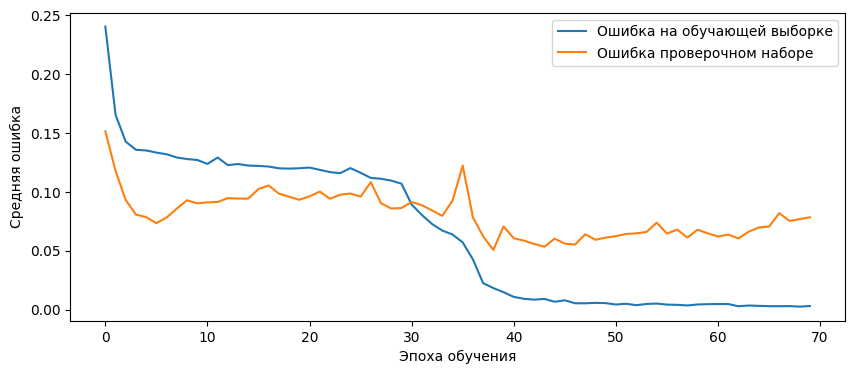

In [ ]:
compare_sharp_loss(history, 10, 4)

F1Score

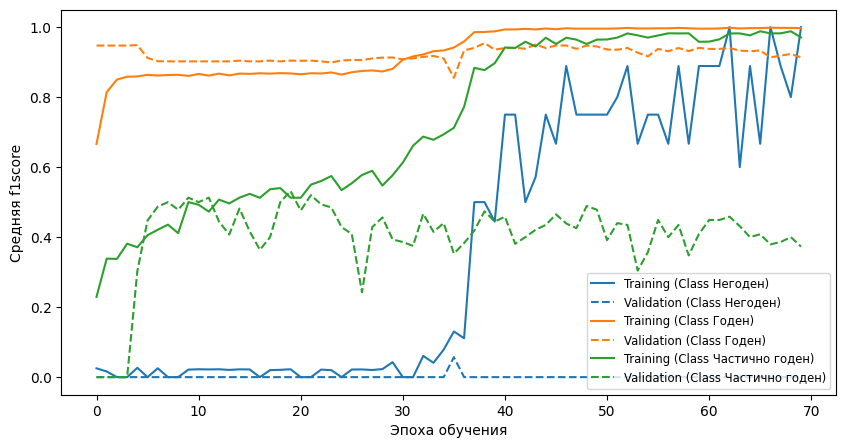

In [ ]:

train_f1scores = np.array(history.history['f1_score'])
val_f1scores = np.array(history.history['val_f1_score'])
plt.figure(figsize=(10,5))

for class_idx in range(Y_CLASSES):
    color = f'C{class_idx}'
    plt.plot(train_f1scores[:, class_idx], color=color, linestyle = '-', label=f'Training (Class {MyUtils.conclusion_map[class_idx]})')
    plt.plot(val_f1scores[:, class_idx], color=color, linestyle = '--',label=f'Validation (Class {MyUtils.conclusion_map[class_idx]})')

plt.legend(fontsize='small')

plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя f1score')

#plt.title("Training and Validation F1 Score by Class")

plt.show()

In [ ]:
y_pred  = model2.predict((x_test, x_test_mkb, x_test_harmfull, x_test_prof, x_test_additions))


10/10 [==============================] - 0s 21ms/step


In [ ]:
print(y_pred[0], '-' , y_test[0])


[1.02908336e-04 9.99894321e-01 2.77734875e-06] - [0 1 0]


In [ ]:
y_pred_idx = np.argmax(y_pred, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
df_result = pd.DataFrame({'pred': y_pred_idx, 'test': y_test_idx})
df_result['pred'] = df_result['pred'].apply(MyUtils.resolve_conclusion_map)
df_result['test'] = df_result['test'].apply(MyUtils.resolve_conclusion_map)
display(df_result)
num_wrong = 0
for pred, test in zip(y_pred_idx, y_test_idx):
    if pred != test:
        num_wrong += 1

percent_wrong = num_wrong / len(y_test_idx) * 100
print(f"Percent wrong: {percent_wrong:.2f}%")


,pred,test
0,Годен,Годен
1,Годен,Годен
2,Годен,Годен
3,Годен,Годен
4,Годен,Годен
...,...,...
308,Годен,Годен
309,Годен,Годен
310,Годен,Годен
311,Годен,Годен


Percent wrong: 10.54%


In [ ]:
(df_result['pred'] != df_result['test']).sum()


33

In [ ]:
# Подсчет общего количества значений в столбце test
total_values = df_result['test'].count()

# Подсчет количества несовпадений
num_mismatches = (df_result['pred'] != df_result['test']).sum()

# Подсчет процентного соотношения несовпадений
mismatch_percentage = (num_mismatches / total_values) * 100
mismatch_percentage


10.543130990415335

In [ ]:
np.argmax(y_pred, axis = -1).shape

(313,)

In [ ]:
np.argmax(y_test, axis = -1).shape

(313,)

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=-1),
                          np.argmax(y_pred, axis=-1),
                          normalize='true')

In [ ]:
cm = np.around(cm, 1)

In [ ]:
MyUtils.conclusion_labels()[np.argmax([1,0,0])]

'Негоден'

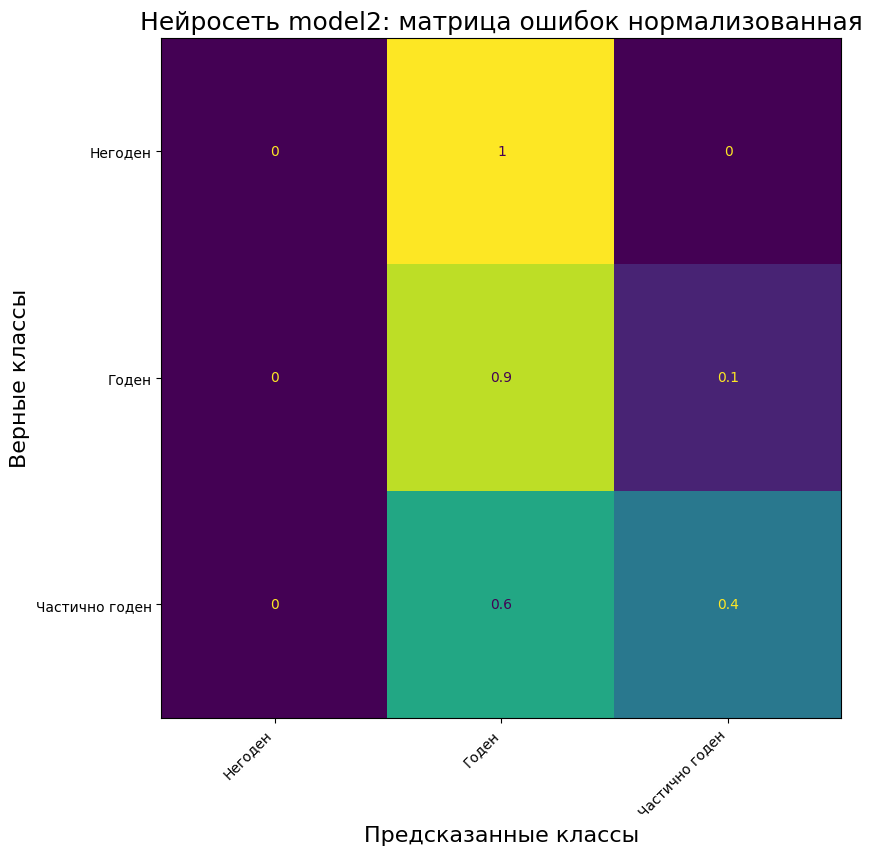

In [ ]:

figsize = (10,10)
title = "model2"
# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MyUtils.conclusion_labels())
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
plt.show()    

In [ ]:
# Подсчет матрицы ошибок
cm = confusion_matrix(y_test_idx, y_pred_idx)

# Подсчет количества верных предсказаний
num_correct = cm.diagonal().sum()

# Подсчет количества ошибочных предсказаний
num_mismatches = cm.sum() - num_correct

# Подсчет процентного соотношения несовпадений
mismatch_percentage = (num_mismatches / cm.sum()) * 100

# Вывод результата
print(f'Количество верных предсказаний: {num_correct}')
print(f'Количество ошибочных предсказаний: {num_mismatches}')
print(f'Процентное соотношение несовпадений: {mismatch_percentage:.2f}%')

Количество верных предсказаний: 280
Количество ошибочных предсказаний: 33
Процентное соотношение несовпадений: 10.54%


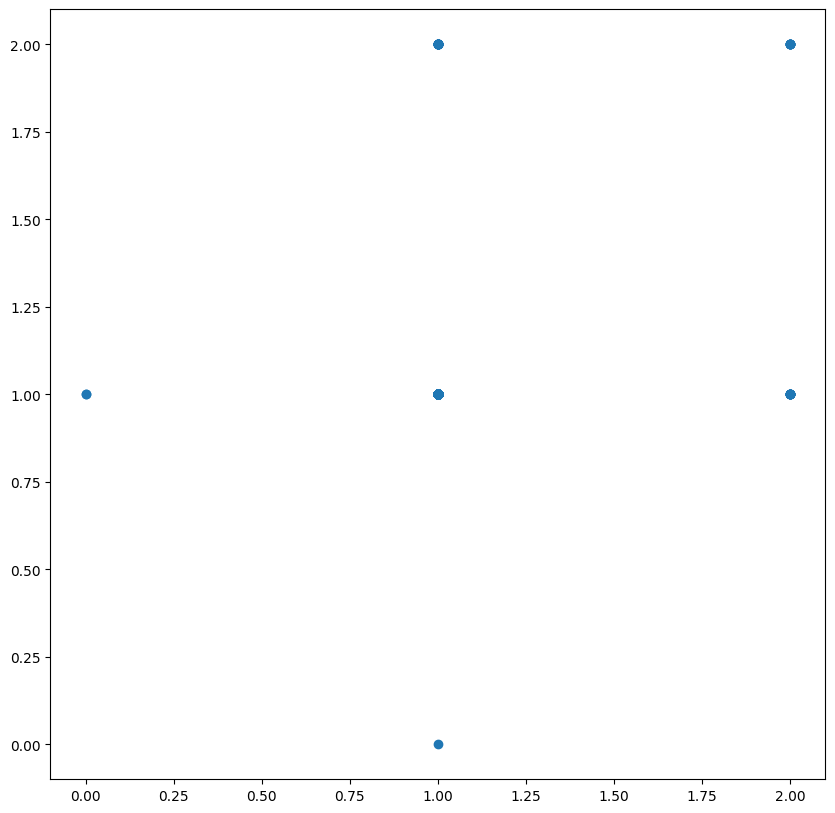

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(y_test_idx, y_pred_idx)

**Вывод**: Основная идея объединить МКБ в одну колонку и пройти по ней как по предложению через свертки, для выявления взаимосвязи между специалистами.

Результат слабоватый, возможно из-за слишком несбалансированнной базы
По этой же причине не стал обрабатывать основные текстовые поля, хотя была та же идея избавится от разрежения значений полей специалистов путём объединения текстов колонок в одну в виде текста с разбивкой на абзацы и заголовками  для каждого специалиста.
Если будет база со сбалансированными данными, возможно это будет уместно сделать 